In [56]:
%reset
from lib import models, graph, coarsening, utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# 1 Data

For the purpose of the demo, let's create a random data matrix $X \in \R^{n \times d_x}$ and somehow infer a label $y_i = f(x_i)$.

In [57]:
d = 500    # Dimensionality.
n = 6654  # Number of samples.
c = 5      # Number of feature communities.
n_test = 1500;
n_train = 4454;
n_val = 700;
x_file = open('Xr500','r');
x_fi = x_file.read();
x_words = x_fi.split();
X = np.array([[0 for j in range(d)] for i in range(5154)]);
i = 0;
for word in x_words:
    X[int(i/d)][i%d] = int(word);
    i+=1;

xte_file = open('Xe500','r');
xte_fi = xte_file.read();
xte_words = xte_fi.split();
X_test = np.array([[0 for j in range(d)] for i in range(1500)]);
i = 0;
for word in xte_words:
    X_test[int(i/d)][i%d] = int(word);
    i+=1;
    
y_file = open('Yr500','r')# np.ones(t.shape, dtype=np.uint8)
y_fi = y_file.read();
y_words = y_fi.split();
y = np.array([0 for i in range(5154)]);
i = 0;
for word in y_words:
    y[i] = int(word);
    i+=1;

yte_file = open('Ye500','r')# np.ones(t.shape, dtype=np.uint8)
yte_fi = yte_file.read();
yte_words = yte_fi.split();
y_test = np.array([0 for i in range(1500)]);
i = 0;
for word in yte_words:
    y_test[i] = int(word);
    i+=1;

# perm_file = open('perm','r')# np.ones(t.shape, dtype=np.uint8)
# perm_fi = perm_file.read();
# perm_words = perm_fi.split();
# perm = np.array([0 for i in range(6654)]);
# i = 0;
# for word in perm_words:
#     perm[i] = int(word);
#     i+=1;

Then split this dataset into training, validation and testing sets.

In [58]:
X_train = np.array([[0 for j in range(d)] for i in range(n_train)]);
X_val = np.array([[0 for j in range(d)] for i in range(n_val)]);

y_train = np.array([0 for i in range(n_train)]);
y_val = np.array([0 for i in range(n_val)]);

ppp = np.random.permutation(5154);

for i in range(0,n_train):
    for j in range(0,d):
        X_train[i,j] = X[ppp[i],j];
    y_train[i] = y[ppp[i]];
for i in range(0,n_val):
    for j in range(0,d):
        X_val[i,j]   = X[ppp[i+n_train],j];
    y_val[i] = y[ppp[i+n_train]];

# 2 Graph

The second thing we need is a **graph between features**, i.e. an adjacency matrix $A \in \mathbb{R}^{d_x \times d_x}$.
Structuring data with graphs is very flexible: it can accomodate both structured and unstructured data.
1. **Structured data**.
    1. The data is structured by an Euclidean domain, e.g. $x_i$ represents an image, a sound or a video. We can use a classical ConvNet with 1D, 2D or 3D convolutions or a graph ConvNet with a line or grid graph (however losing the orientation).
    2. The data is structured by a graph, e.g. the data lies on a transportation, energy, brain or social network.
2. **Unstructured data**. We could use a fully connected network, but the learning and computational complexities are gonna be large. An alternative is to construct a sparse similarity graph between features (or between samples) and use a graph ConvNet, effectively structuring the data and drastically reducing the number of parameters through weight sharing. As for classical ConvNets, the number of parameters are independent of the input size.

There are many ways, supervised or unsupervised, to construct a graph given some data. And better the graph, better the performance ! For this example we'll define the adjacency matrix as a simple similarity measure between features. Below are the choices one has to make when constructing such a graph.
1. The distance function. We'll use the Euclidean distance $d_{ij} = \|x_i - x_j\|_2$.
2. The kernel. We'll use the Gaussian kernel $a_{ij} = \exp(d_{ij}^2 / \sigma^2)$.
3. The type of graph. We'll use a $k$ nearest neigbors (kNN) graph.

To be able to pool graph signals, we need first to coarsen the graph, i.e. to find which vertices to group together. At the end we'll have multiple graphs, like a pyramid, each at one level of resolution. The finest graph is where the input data lies, the coarsest graph is where the data at the output of the graph convolutional layers lie. That data, of reduced spatial dimensionality, can then be fed to a fully connected layer.

The parameter here is the number of times to coarsen the graph. Each coarsening approximately reduces the size of the graph by a factor two. Thus if you want a pooling of size 4 in the first layer followed by a pooling of size 2 in the second, you'll need to coarsen $\log_2(4+2) = 3$ times.

After coarsening we rearrange the vertices (and add fake vertices) such that pooling a graph signal is analog to pooling a 1D signal. See the [paper] for details.

[paper]: https://arxiv.org/abs/1606.09375

d = |V| = 500, k|V| < |E| = 4832


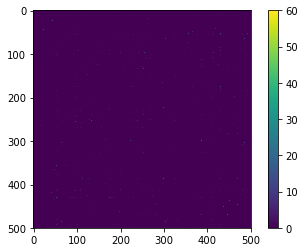

In [59]:
# aa = open("Adj500");
# aa = aa.read();
# aa = aa.split();
# w, h = 4096, 100;
# A_temp = [[0 for xx in range(w)] for yy in range(h)];
# for i in range(0,409600):
#     A_temp[i//4096][i%4096] = float(aa[i]);

# dist, idx = graph.distance_scipy_spatial(A_temp, k=20, metric='euclidean')
# A = graph.adjacency(dist, idx).astype(np.float32);



aa = open("matr500");
aa = aa.read();
s1 = aa.split();
w,h = d,d;
matr = np.zeros((w,h));
row = [];
col = [];
data = [];
for i in range(0,d):
    for j in range(0,d):
        matr[i][j] = np.float32(float(s1[i*d+j]));
        if float(s1[i*d+j]) != 0.0:
            row.append(i);
            col.append(j);
            data.append(np.float32(float(s1[i*d+j])));
plt.imshow(matr);
plt.colorbar();
row = np.array(row);
col = np.array(col);
data = np.array(data);
A = csr_matrix((data, (row, col)), shape=(d, d));

assert A.shape == (d, d)
print('d = |V| = {}, k|V| < |E| = {}'.format(d, A.nnz))
# plt.spy(A, markersize=1, color='black');
# cn = np.arange(50);
# for i in range(0,len(y_train)):
#     cn[y_train[i]]+=1;
# print(cn);
# bins = np.linspace(0,48,49);
# plt.hist(y_train,bins);

In [60]:
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)

X_train = coarsening.perm_data(X_train, perm)
X_val = coarsening.perm_data(X_val, perm)
X_test = coarsening.perm_data(X_test, perm)

Layer 0: M_0 = |V| = 712 nodes (212 added),|E| = 2416 edges
Layer 1: M_1 = |V| = 356 nodes (40 added),|E| = 2212 edges
Layer 2: M_2 = |V| = 178 nodes (3 added),|E| = 1895 edges
Layer 3: M_3 = |V| = 89 nodes (0 added),|E| = 1312 edges


/users/neeraj.b/project/cnn_graph/lib/coarsening.py:152: RuntimeWarning: divide by zero encountered in true_divide
  tval = vv[rs+jj] * (1.0/weights[tid] + 1.0/weights[nid])


We finally need to compute the graph Laplacian $L$ for each of our graphs (the original and the coarsened versions), defined by their adjacency matrices $A$. The sole parameter here is the type of Laplacian, e.g. the combinatorial Laplacian, the normalized Laplacian or the random walk Laplacian.

/users/neeraj.b/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


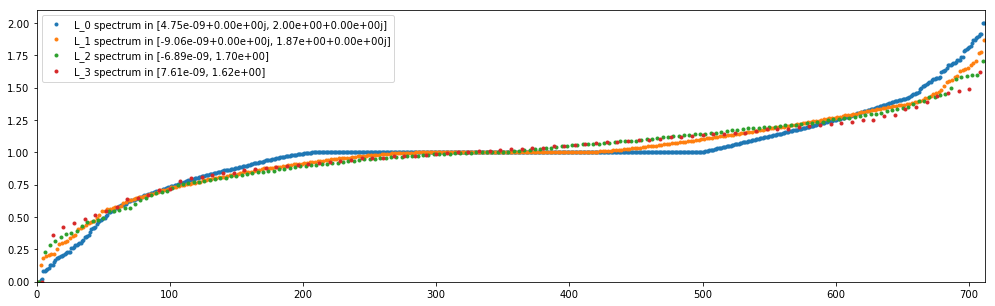

In [61]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

# 3 Graph ConvNet

Here we apply the graph convolutional neural network to signals lying on graphs. After designing the architecture and setting the hyper-parameters, the model takes as inputs the data matrix $X$, the target $y$ and a list of graph Laplacians $L$, one per coarsening level.

The data, architecture and hyper-parameters are absolutely *not engineered to showcase performance*. Its sole purpose is to illustrate usage and functionality.

In [62]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 80
params['batch_size']     = 100
params['eval_frequency'] = 200

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = y.max() + 1
# assert C == np.unique(y).size

# Architecture.
params['F']              = [32, 64]  # Number of graph convolutional filters.
params['K']              = [100, 100]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

In [63]:
model = models.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

NN architecture
  input: M_0 = 712
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 712 * 32 / 4 = 5696
    weights: F_0 * F_1 * K_1 = 1 * 32 * 100 = 3200
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 178 * 64 / 2 = 5696
    weights: F_1 * F_2 * K_2 = 32 * 64 * 100 = 204800
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 5696 * 512 = 2916352
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 50
    weights: M_3 * M_4 = 512 * 50 = 25600
    biases: M_4 = 50
step 200 / 3563 (epoch 4.49 / 80):
  learning_rate = 8.15e-04, loss_average = 8.41e+00


/users/neeraj.b/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 31.00 (217 / 700), f1 (weighted): 27.72, loss: 8.48e+00
  time: 272s (wall 368s)
step 400 / 3563 (epoch 8.98 / 80):
  learning_rate = 6.63e-04, loss_average = 7.76e+00
  validation accuracy: 44.57 (312 / 700), f1 (weighted): 43.25, loss: 7.93e+00
  time: 544s (wall 738s)
step 600 / 3563 (epoch 13.47 / 80):
  learning_rate = 5.13e-04, loss_average = 7.41e+00
  validation accuracy: 48.57 (340 / 700), f1 (weighted): 47.35, loss: 7.68e+00
  time: 816s (wall 1108s)
step 800 / 3563 (epoch 17.96 / 80):
  learning_rate = 4.18e-04, loss_average = 7.28e+00
  validation accuracy: 48.29 (338 / 700), f1 (weighted): 48.15, loss: 7.57e+00
  time: 1089s (wall 1477s)
step 1000 / 3563 (epoch 22.45 / 80):
  learning_rate = 3.24e-04, loss_average = 7.19e+00
  validation accuracy: 52.14 (365 / 700), f1 (weighted): 51.86, loss: 7.47e+00
  time: 1361s (wall 1847s)
step 1200 / 3563 (epoch 26.94 / 80):
  learning_rate = 2.64e-04, loss_average = 7.10e+00
  validation accuracy: 50.86 (356 

# 4 Evaluation

We often want to monitor:
1. The convergence, i.e. the training loss and the classification accuracy on the validation set.
2. The performance, i.e. the classification accuracy on the testing set (to be compared with the training set accuracy to spot overfitting).

The `model_perf` class in [utils.py](utils.py) can be used to compactly evaluate multiple models.

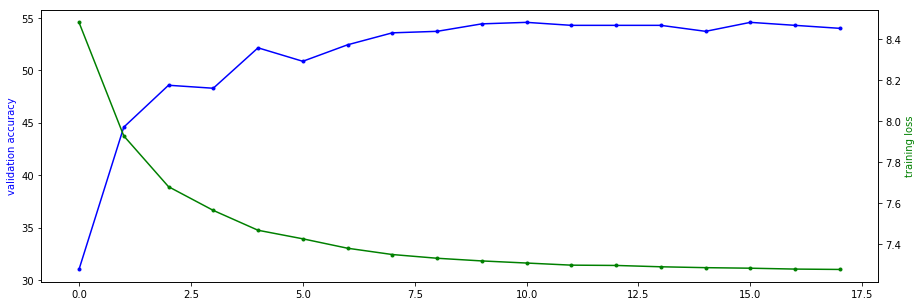

In [64]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accuracy, 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(loss, 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

In [65]:
print('Time per step: {:.2f} ms'.format(t_step*1000))

Time per step: 1849.74 ms


In [66]:
res = model.evaluate(X_test, y_test)
print(res[0])

accuracy: 55.67 (835 / 1500), f1 (weighted): 55.28, loss: 7.27e+00
time: 14s (wall 13s)
